# Generate Local Feature Vector

This notebook gives a demonstration of how the local feature vectors are generated and also produces graphical output for verification that all components are working as expected. For ease of use, this notebook is written to explore the local feature vectors of just a single input image.

## Imports

The following packages are required by this procedure.

In [51]:
# Math Imports
import scipy.misc
import numpy as np
import math

# Image Analysis Imports
import scipy.ndimage
from scipy.ndimage import interpolation
from skimage import morphology

# Visualization Imports
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn.apionly as sns 

%matplotlib inline

## Set up local environment variables

In [52]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'

sBmp = 'bmps/%06d.bmp'
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
crop_radius = 175 # Radius of circular crop
wavelength = 30 # Width of a single roll


## Load image

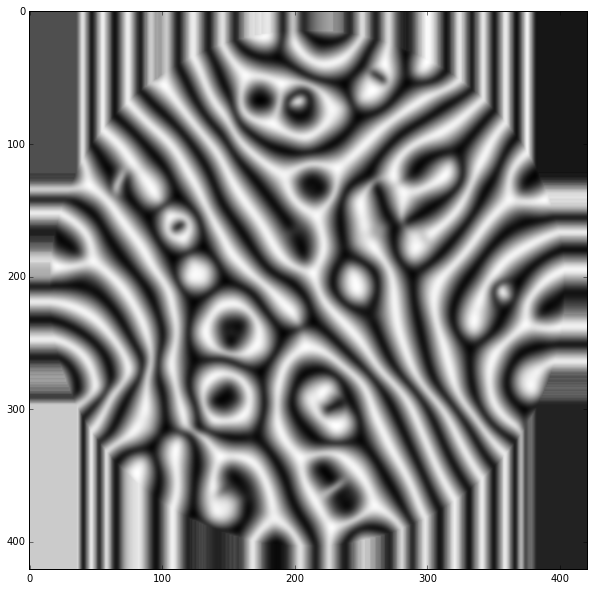

In [53]:
idx = 500
bmp = scipy.misc.imread(sDir + "/" + (sBmp % idx))

plt.rcParams['figure.figsize'] = (10.0, 10.0);
plt.set_cmap('gray');
plt.imshow(bmp);

## Investigate Local Feature Vector at a Point

Choose a coordinate from the image above with which to explore the local feature vector at that point.

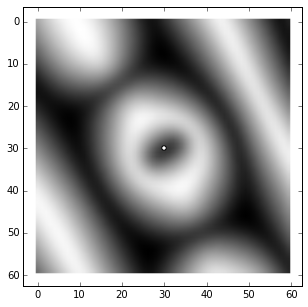

In [99]:
row, col = (162, 112)

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)]);
plt.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');


## Assign Dominant Orientation to the Local Feature Vector

For rotation invariance, each local feature must have an ambient orientation assigned to it. This corresponds to the dominant mode in the orientation histogram about the point on which the local feature vector sits. This procedure requires a few things:
- Compute the orientation field
- Compute the histogram of orientations about the selected point
- Choose the dominant orientation and assign it to the local feature vector

### Compute the orientation field

This code was written by Shaun Harker and is based on

> Bazen, Asker M., and Sabih H. Gerez. "Systematic methods for the computation of the directional fields and singular points of fingerprints." IEEE transactions on pattern analysis and machine intelligence 24.7 (2002): 905-919.

The orientation field has values in [-pi/2, pi/2], where the slope of the director field matches the sign of the orientation.

In [100]:
def orientation_field(du, radius=5):
    """
    Computes orientation field (result everywhere between -pi/2 and pi/2)
    given vector field
    """
    [ux, uy] = du
    Y = scipy.ndimage.filters.gaussian_filter(2.0*ux*uy, sigma=radius)
    X = scipy.ndimage.filters.gaussian_filter(ux**2.0 - uy**2.0, sigma=radius)
    return .5 * np.arctan2(Y, X)


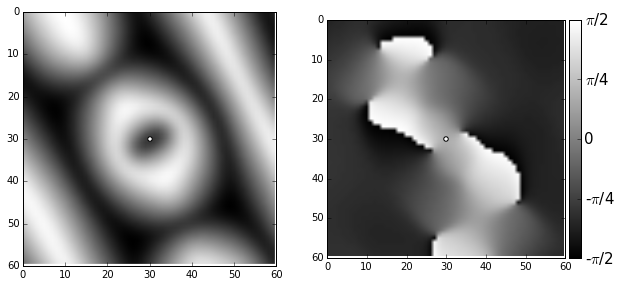

In [101]:
orientation_field_blur_radius = 3 # Amount of smoothing to apply

u = bmp.astype(float)
du = np.gradient(u)
of = orientation_field(du, orientation_field_blur_radius)

# Plot the cropped temperature field
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)]);
plt.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');
ax.set_xlim([0,bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[1]]);
ax.set_ylim([bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[0],0]);

# Plot the cropped orientation field
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(of[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)]);
ax.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');
divider = make_axes_locatable(ax);
cax = divider.append_axes("right", size="5%", pad=0.05);
ax2 = plt.colorbar(im, cax=cax, ticks=[-math.pi/2., -math.pi/4., 0, math.pi/4., math.pi/2.]);
ax2.set_clim(-math.pi/2., math.pi/2.);
ax2.ax.tick_params(labelsize=15);
ax2.draw_all();
ax2.ax.set_yticklabels(['-$\pi$/2', '-$\pi$/4', '0', '$\pi$/4', '$\pi$/2']);
ax.set_xlim([0,of[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[1]]);
ax.set_ylim([of[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[0],0]);


### Compute the histogram of orientations to get the max orientation

We perform a circular crop of the orientation field about the point and then compute the histogram of orientations, binning the values.

In [102]:
def getOrientationHistogram(_of, _position, _nbins, _radius):
    
    # Get circular crop
    crop = np.zeros((_radius*2, _radius*2))
    crop[_radius, _radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(_radius))
    
    # Crop the orientation field
    cropped_orientation = _of[(_position[0]-_radius):(_position[0]+_radius), (_position[1]-_radius):(_position[1]+_radius)]
    
    # Get histogram for the orientation field
    hist = np.histogram(cropped_orientation[crop==1], bins=_nbins, range=(-math.pi/2.,math.pi/2.))[0]
    
    plt.plot(hist);
    plt.plot([0, keypoint_orientation_bins-1], [0.8*max(hist), 0.8*max(hist)]);
    plt.show()
    
    return hist
    

In [103]:
def convertMainOrientationBin(_bin, _nbins):
    # Convert from [0,_nbins] to [0,180] to [0,pi]
    orientation = math.radians(_bin*180.*(1./_nbins))
    # Convert from [0,pi] to [-pi/2, pi/2]
    orientation = orientation - math.pi/2.
    # Convert from [-pi/2, pi/2] to [pi/2 -> -pi/2 decreasing]
    orientation = orientation*-1.
    
    return orientation


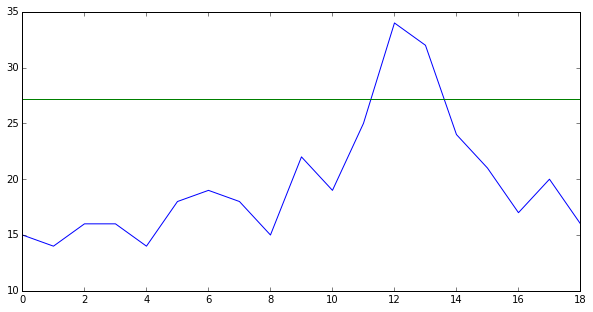

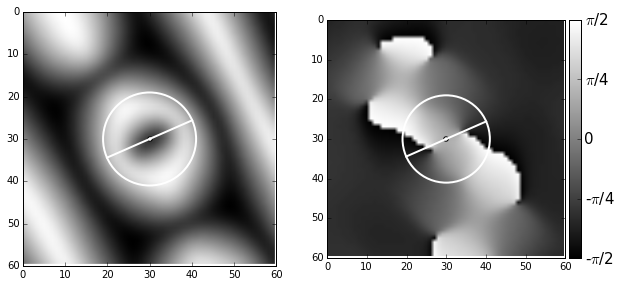

In [104]:
# Variables for assigning orientations to the local feature vector
keypoint_orientation_bins = 19
keypoint_radius = 11 # Radius within which to collect orientation data

histogram = getOrientationHistogram(of, [row, col], keypoint_orientation_bins, keypoint_radius)

max_orientation_bin = np.argmax(histogram)
orientation_rad = convertMainOrientationBin(max_orientation_bin, keypoint_orientation_bins)

# Plot the cropped temperature field
plt.rcParams['figure.figsize'] = (10.0, 5.0);
plt.subplot(1,2,1);
ax = plt.gca();
plt.imshow(bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)]);
plt.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');
circle1 = plt.Circle((wavelength, wavelength), keypoint_radius, color='white', fill=False, lw=2);
ax.add_artist(circle1);
ax.plot([(wavelength - keypoint_radius*math.cos(orientation_rad)), (wavelength + keypoint_radius*math.cos(orientation_rad))], \
         [(wavelength - keypoint_radius*math.sin(orientation_rad)), (wavelength + keypoint_radius*math.sin(orientation_rad))], \
color='white', lw=2);
ax.set_xlim([0,bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[1]]);
ax.set_ylim([bmp[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[0],0]);

# Plot the cropped orientation field
plt.subplot(1,2,2);
ax = plt.gca();
im = ax.imshow(of[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)]);
ax.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');
divider = make_axes_locatable(ax);
cax = divider.append_axes("right", size="5%", pad=0.05);
ax2 = plt.colorbar(im, cax=cax, ticks=[-math.pi/2., -math.pi/4., 0, math.pi/4., math.pi/2.]);
ax2.set_clim(-math.pi/2., math.pi/2.);
ax2.ax.tick_params(labelsize=15);
ax2.draw_all();
ax2.ax.set_yticklabels(['-$\pi$/2', '-$\pi$/4', '0', '$\pi$/4', '$\pi$/2']);
circle1 = plt.Circle((wavelength, wavelength), keypoint_radius, color='white', fill=False, lw=2);
ax.add_artist(circle1);
ax.plot([(wavelength - keypoint_radius*math.cos(orientation_rad)), (wavelength + keypoint_radius*math.cos(orientation_rad))], \
         [(wavelength - keypoint_radius*math.sin(orientation_rad)), (wavelength + keypoint_radius*math.sin(orientation_rad))], \
color='white', lw=2);
ax.set_xlim([0,of[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[1]]);
ax.set_ylim([of[(row - wavelength):(row+wavelength), (col-wavelength):(col + wavelength)].shape[0],0]);


### Compute the Local Feature Vector

Rotate the input image so that the max orientation at that point is zero (horizontal), and then compute the vector of orientation histograms corresponding to the eight regions in the cross-hairs about the point.

#### Rotate Image and compute Orientation Field

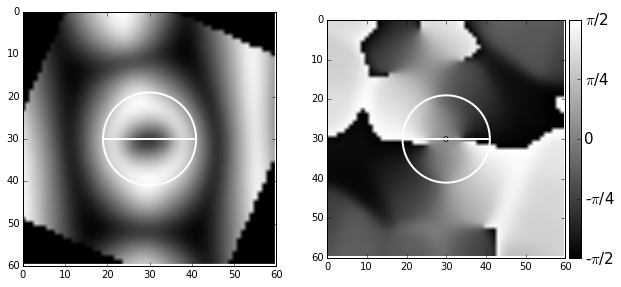

In [105]:
cropped_bmp = bmp[(row-wavelength):(row+wavelength), (col-wavelength):(col+wavelength)]
rotated_image = interpolation.rotate(cropped_bmp, math.degrees(orientation_rad), reshape=False)

rotated_u = rotated_image.astype(float)
rotated_du = np.gradient(rotated_u)
rotated_of = orientation_field(rotated_du, orientation_field_blur_radius)

# Plot rotated temperature field
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.subplot(1,2,1);
ax = plt.gca();
plt.imshow(rotated_image)
plt.plot([(wavelength - keypoint_radius*math.cos(0)), (wavelength + keypoint_radius*math.cos(0))], \
         [(wavelength - keypoint_radius*math.sin(0)), (wavelength + keypoint_radius*math.sin(0))], \
color='white', lw=2);
circle1 = plt.Circle((wavelength, wavelength), keypoint_radius, color='white', fill=False, lw=2);
ax.add_artist(circle1);
ax.set_xlim([0,rotated_image.shape[1]]);
ax.set_ylim([rotated_image.shape[0],0]);


# Plot orientation field of rotated temperature field
plt.subplot(1,2,2)
ax = plt.gca()
im = ax.imshow(rotated_of);
ax.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');
divider = make_axes_locatable(ax);
cax = divider.append_axes("right", size="5%", pad=0.05);
ax2 = plt.colorbar(im, cax=cax, ticks=[-math.pi/2., -math.pi/4., 0, math.pi/4., math.pi/2.]);
ax2.set_clim(-math.pi/2., math.pi/2.);
ax2.ax.tick_params(labelsize=15);
ax2.draw_all();
ax2.ax.set_yticklabels(['-$\pi$/2', '-$\pi$/4', '0', '$\pi$/4', '$\pi$/2']);
circle1 = plt.Circle((wavelength, wavelength), keypoint_radius, color='white', fill=False, lw=2);
ax.add_artist(circle1);
ax.plot([(wavelength - keypoint_radius*math.cos(0)), (wavelength + keypoint_radius*math.cos(0))], \
         [(wavelength - keypoint_radius*math.sin(0)), (wavelength + keypoint_radius*math.sin(0))], \
color='white', lw=2);
ax.set_xlim([0,rotated_of.shape[1]]);
ax.set_ylim([rotated_of.shape[0],0]);




#### Generate Vector of Local Histograms

In [106]:
def getFeatureVector(_bmp, _of, _radius, _inner_radius_factor, _nbins, _outer_radius_discount):
    """
    Takes in a single local patch from the orientation field and generates local feature vector from it.
    Circular patch of given radius centered at middle of image is cropped from orientation field and divided
    into eight localized patches.
    
    Each smaller patch gets an orientation histogram with the supplied number
    of bins. The value in each bin is the output feature vector for that localized patch, and each of the
    eight localized patches are concatenated together to form a feature vector of length 4*nbins.
    
    The eight localized patches are concentric quadrants of two circles at an outer radius of radius and
    an inner radius of _radius*_inner_radius_factor.
    """
    
    inner_radius = int(_radius*_inner_radius_factor)
    outer_radius = _radius
    
    # GAUSSIAN WEIGHTS
    weights = np.ones(_bmp.shape)*_outer_radius_discount
    inner_weights = weights[(_bmp.shape[0]/2 - inner_radius):(_bmp.shape[0]/2+inner_radius), (_bmp.shape[0]/2 - inner_radius):(_bmp.shape[0]/2+inner_radius)]
    inner_weights = np.ones(inner_weights.shape)
    
    # INNER CIRCLE
    # Get circular crop
    crop = np.zeros((inner_radius*2, inner_radius*2))
    crop[inner_radius, inner_radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(inner_radius))
    
    # Variable for radius
    tmp_radius = inner_radius
    
    # Rotate cropped orientation field: scale to 180 degrees, subtract rotation, then scale to 255
    rotated_orientation = _of[(_bmp.shape[0]/2 - tmp_radius):(_bmp.shape[0]/2 + tmp_radius), (_bmp.shape[0]/2 - tmp_radius):(_bmp.shape[0]/2 + tmp_radius) ]

    # Get histogram for each of the four inner subregions
    hist11_inner = np.histogram(rotated_orientation[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=inner_weights[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]])[0]
    hist12_inner = np.histogram(rotated_orientation[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=inner_weights[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]])[0]
    hist21_inner = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=inner_weights[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]])[0]
    hist22_inner = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=inner_weights[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]])[0]
    
    # OUTER CIRCLE
    # Get circular crop
    crop = np.zeros((outer_radius*2, outer_radius*2))
    crop[outer_radius, outer_radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(outer_radius))
    remove = np.zeros((outer_radius*2, outer_radius*2))
    remove[outer_radius, outer_radius] = 1
    remove = morphology.binary_dilation(remove, morphology.disk(inner_radius))
    crop = crop ^ remove
    
    # Variable for radius
    tmp_radius = outer_radius
    
    # Rotate cropped orientation field: scale to 180 degrees, subtract rotation, then scale to 255
    rotated_orientation = _of[(_bmp.shape[0]/2 - tmp_radius):(_bmp.shape[0]/2 + tmp_radius), (_bmp.shape[0]/2 - tmp_radius):(_bmp.shape[0]/2 + tmp_radius) ]

    # Get histogram for each of the four outer subregions
    tmp_radius = outer_radius
    hist11_outer = np.histogram(rotated_orientation[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=weights[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]])[0]
    hist12_outer = np.histogram(rotated_orientation[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=weights[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]])[0]
    hist21_outer = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=weights[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]])[0]
    hist22_outer = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]], bins=_nbins, range=(-math.pi/2.,math.pi/2.), weights=weights[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]])[0]
    
    
    # Return feature vector
    featurevector = np.concatenate((hist11_inner, hist12_inner, hist21_inner, hist22_inner, hist11_outer, hist12_outer, hist21_outer, hist22_outer), axis=0)

    return featurevector

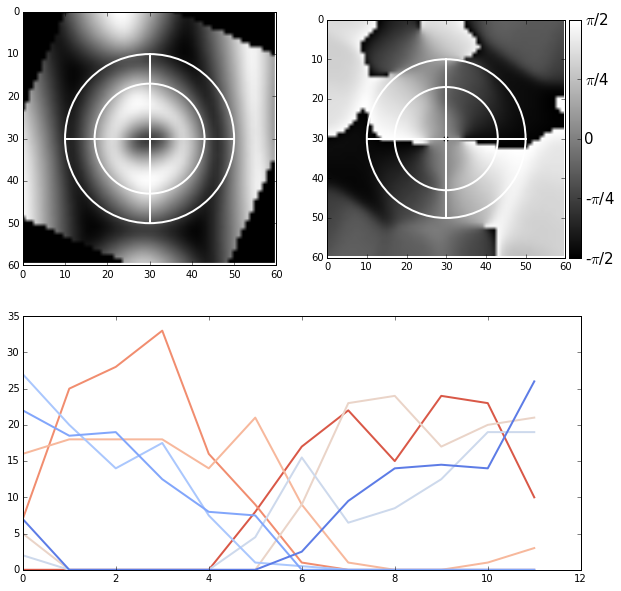

In [107]:
# Variables for the local feature
feature_radius = 20
feature_inner_radius_factor = 0.65
feature_orientation_bins = 12
feature_outer_radius_discount = 0.5

local_features = getFeatureVector(rotated_image, rotated_of, feature_radius, feature_inner_radius_factor, feature_orientation_bins, feature_outer_radius_discount)


plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Plot rotated temperature field
plt.subplot(2,2,1);
ax = plt.gca();
plt.imshow(rotated_image)
plt.plot([(wavelength - feature_radius), (wavelength + feature_radius)], \
         [(wavelength), (wavelength)], \
color='white', lw=2);
plt.plot([(wavelength), (wavelength)], \
         [(wavelength - feature_radius), (wavelength + feature_radius)], \
color='white', lw=2);
circle1 = plt.Circle((wavelength, wavelength), feature_radius, color='white', fill=False, lw=2);
ax.add_artist(circle1);
circle2 = plt.Circle((wavelength, wavelength), feature_radius*feature_inner_radius_factor, color='white', fill=False, lw=2);
ax.add_artist(circle2);
ax.set_xlim([0,rotated_image.shape[1]])
ax.set_ylim([rotated_image.shape[0],0])

# Plot orientation field of rotated temperature field
plt.subplot(2,2,2)
ax = plt.gca()
im = ax.imshow(rotated_of);
ax.scatter([wavelength], [wavelength], color='white', linewidth=1, edgecolor='black');
divider = make_axes_locatable(ax);
cax = divider.append_axes("right", size="5%", pad=0.05);
ax2 = plt.colorbar(im, cax=cax, ticks=[-math.pi/2., -math.pi/4., 0, math.pi/4., math.pi/2.]);
ax2.set_clim(-math.pi/2., math.pi/2.);
ax2.ax.tick_params(labelsize=15);
ax2.draw_all();
ax2.ax.set_yticklabels(['-$\pi$/2', '-$\pi$/4', '0', '$\pi$/4', '$\pi$/2']);
circle1 = plt.Circle((wavelength, wavelength), feature_radius, color='white', fill=False, lw=2);
ax.add_artist(circle1);
circle2 = plt.Circle((wavelength, wavelength), feature_radius*feature_inner_radius_factor, color='white', fill=False, lw=2);
ax.add_artist(circle2);
ax.plot([(wavelength - feature_radius), (wavelength + feature_radius)], \
         [(wavelength), (wavelength)], \
color='white', lw=2);
ax.plot([(wavelength), (wavelength)], \
         [(wavelength - feature_radius), (wavelength + feature_radius)], \
color='white', lw=2);
ax.set_xlim([0,rotated_of.shape[1]])
ax.set_ylim([rotated_of.shape[0],0])


plt.subplot(2,1,2)
ax = plt.gca()
ax.set_color_cycle(sns.color_palette("coolwarm_r",8))
plt.plot(np.reshape(local_features, (8,feature_orientation_bins)).T, lw=2);